<a href="https://colab.research.google.com/github/VIKASRAJPUT10/vikas/blob/main/sports_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d gpiosenka/sports-classification

sports-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/sports-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras import callbacks
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions


plt.rcParams['figure.figsize']= (20,8)

In [ ]:
img_size = 224
batch_size= 20

train_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)


test_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)


train_generator = train_datagen.flow_from_directory('/content/train',
                                                    target_size= (img_size, img_size),
                                                    batch_size = batch_size,
                                                    shuffle = True,
                                                    class_mode ='categorical')

val_generator = val_datagen.flow_from_directory('/content/valid',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                shuffle = False,
                                                class_mode ='categorical')

test_generator = test_datagen.flow_from_directory('/content/test',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                shuffle = False,
                                                class_mode ='categorical')

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [ ]:
train_generator.color_mode

'rgb'

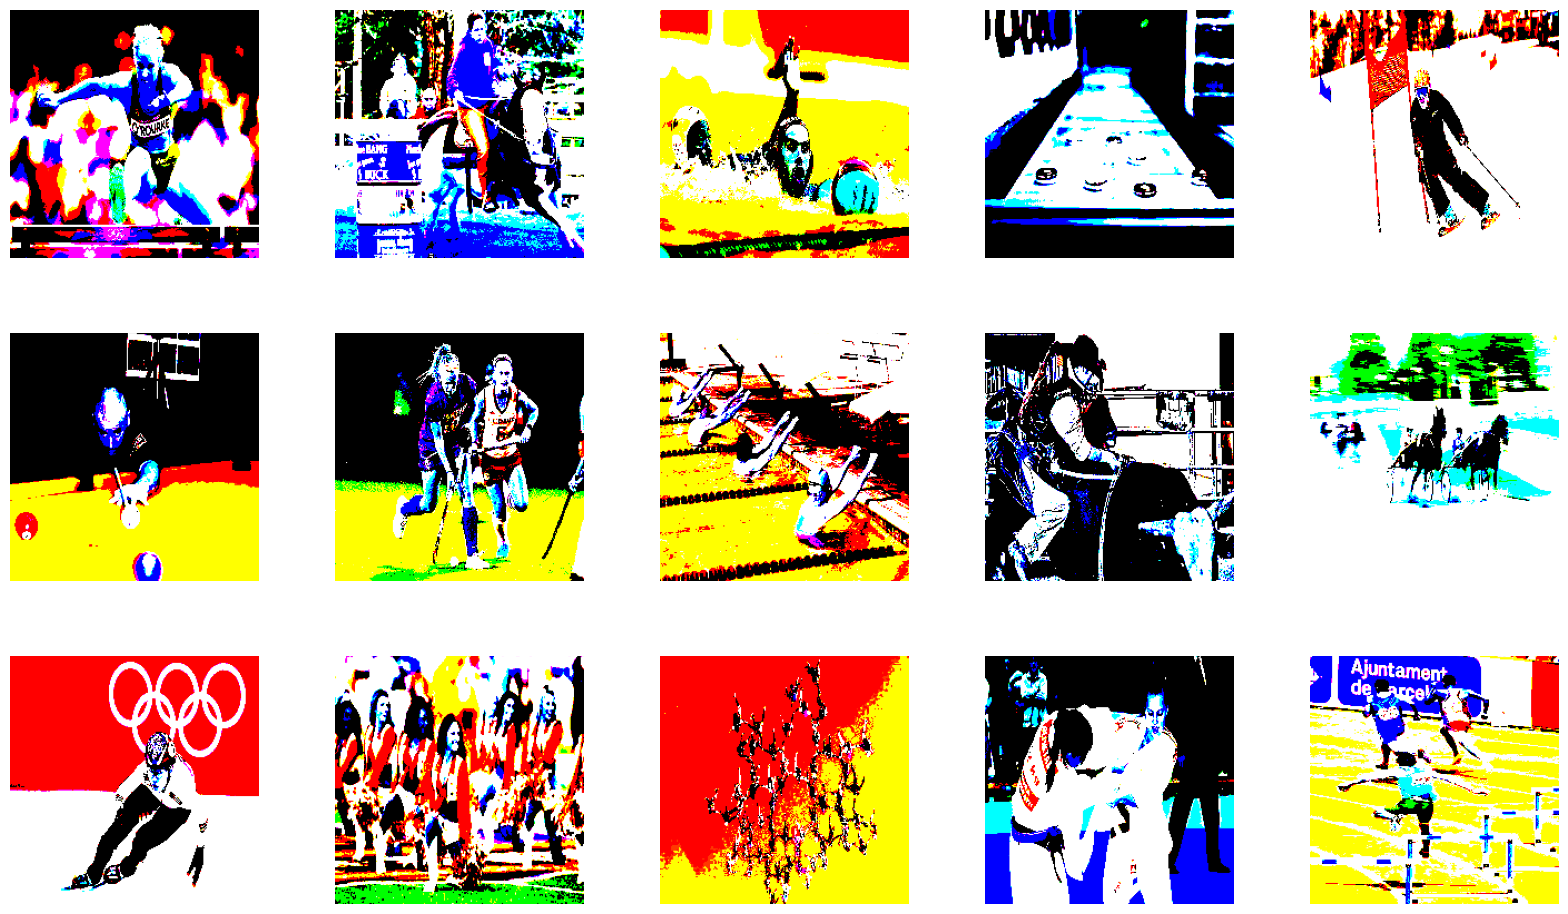

In [ ]:
samples = train_generator.__next__()
images = samples[0]
target = samples[1]

plt.figure(figsize = (20,20))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(images[i])
    plt.axis('off')

In [ ]:
resnet_weights_path = 'imagenet'

In [ ]:
model = Sequential()

model.add(ResNet50(include_top = False, pooling = 'avg',
                  weights = resnet_weights_path))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model.add(Dense(100, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
Total params: 23,792,612
Trainable params: 23,739,492
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model.layers

In [ ]:
model.layers[0].trainable = False


In [ ]:
model.compile(optimizer= 'sgd',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    validation_data = val_generator, epochs = 8)

Epoch 1/8
675/675 [==============================] - 64s 78ms/step - loss: 1.6035 - accuracy: 0.6379 - val_loss: 0.5667 - val_accuracy: 0.8680
Epoch 2/8
675/675 [==============================] - 53s 78ms/step - loss: 0.5216 - accuracy: 0.8816 - val_loss: 0.3730 - val_accuracy: 0.9140
Epoch 3/8
675/675 [==============================] - 56s 84ms/step - loss: 0.3560 - accuracy: 0.9235 - val_loss: 0.3122 - val_accuracy: 0.9180
Epoch 4/8
675/675 [==============================] - 52s 77ms/step - loss: 0.2748 - accuracy: 0.9452 - val_loss: 0.2580 - val_accuracy: 0.9340
Epoch 5/8
675/675 [==============================] - 54s 81ms/step - loss: 0.2235 - accuracy: 0.9580 - val_loss: 0.2344 - val_accuracy: 0.9420
Epoch 6/8
675/675 [==============================] - 53s 78ms/step - loss: 0.1878 - accuracy: 0.9689 - val_loss: 0.2224 - val_accuracy: 0.9420
Epoch 7/8
675/675 [==============================] - 53s 79ms/step - loss: 0.1611 - accuracy: 0.9757 - val_loss: 0.2122 - val_accuracy: 0.9400

In [ ]:
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,1.603495,0.637934,0.566661,0.868
1,0.521614,0.881634,0.373046,0.914
2,0.356036,0.923510,0.312249,0.918
3,0.274788,0.945153,0.257997,0.934
4,0.223537,0.957975,0.234378,0.942
5,0.187783,0.968870,0.222433,0.942
6,0.161056,0.975689,0.212208,0.940
7,0.140613,0.980136,0.194054,0.948


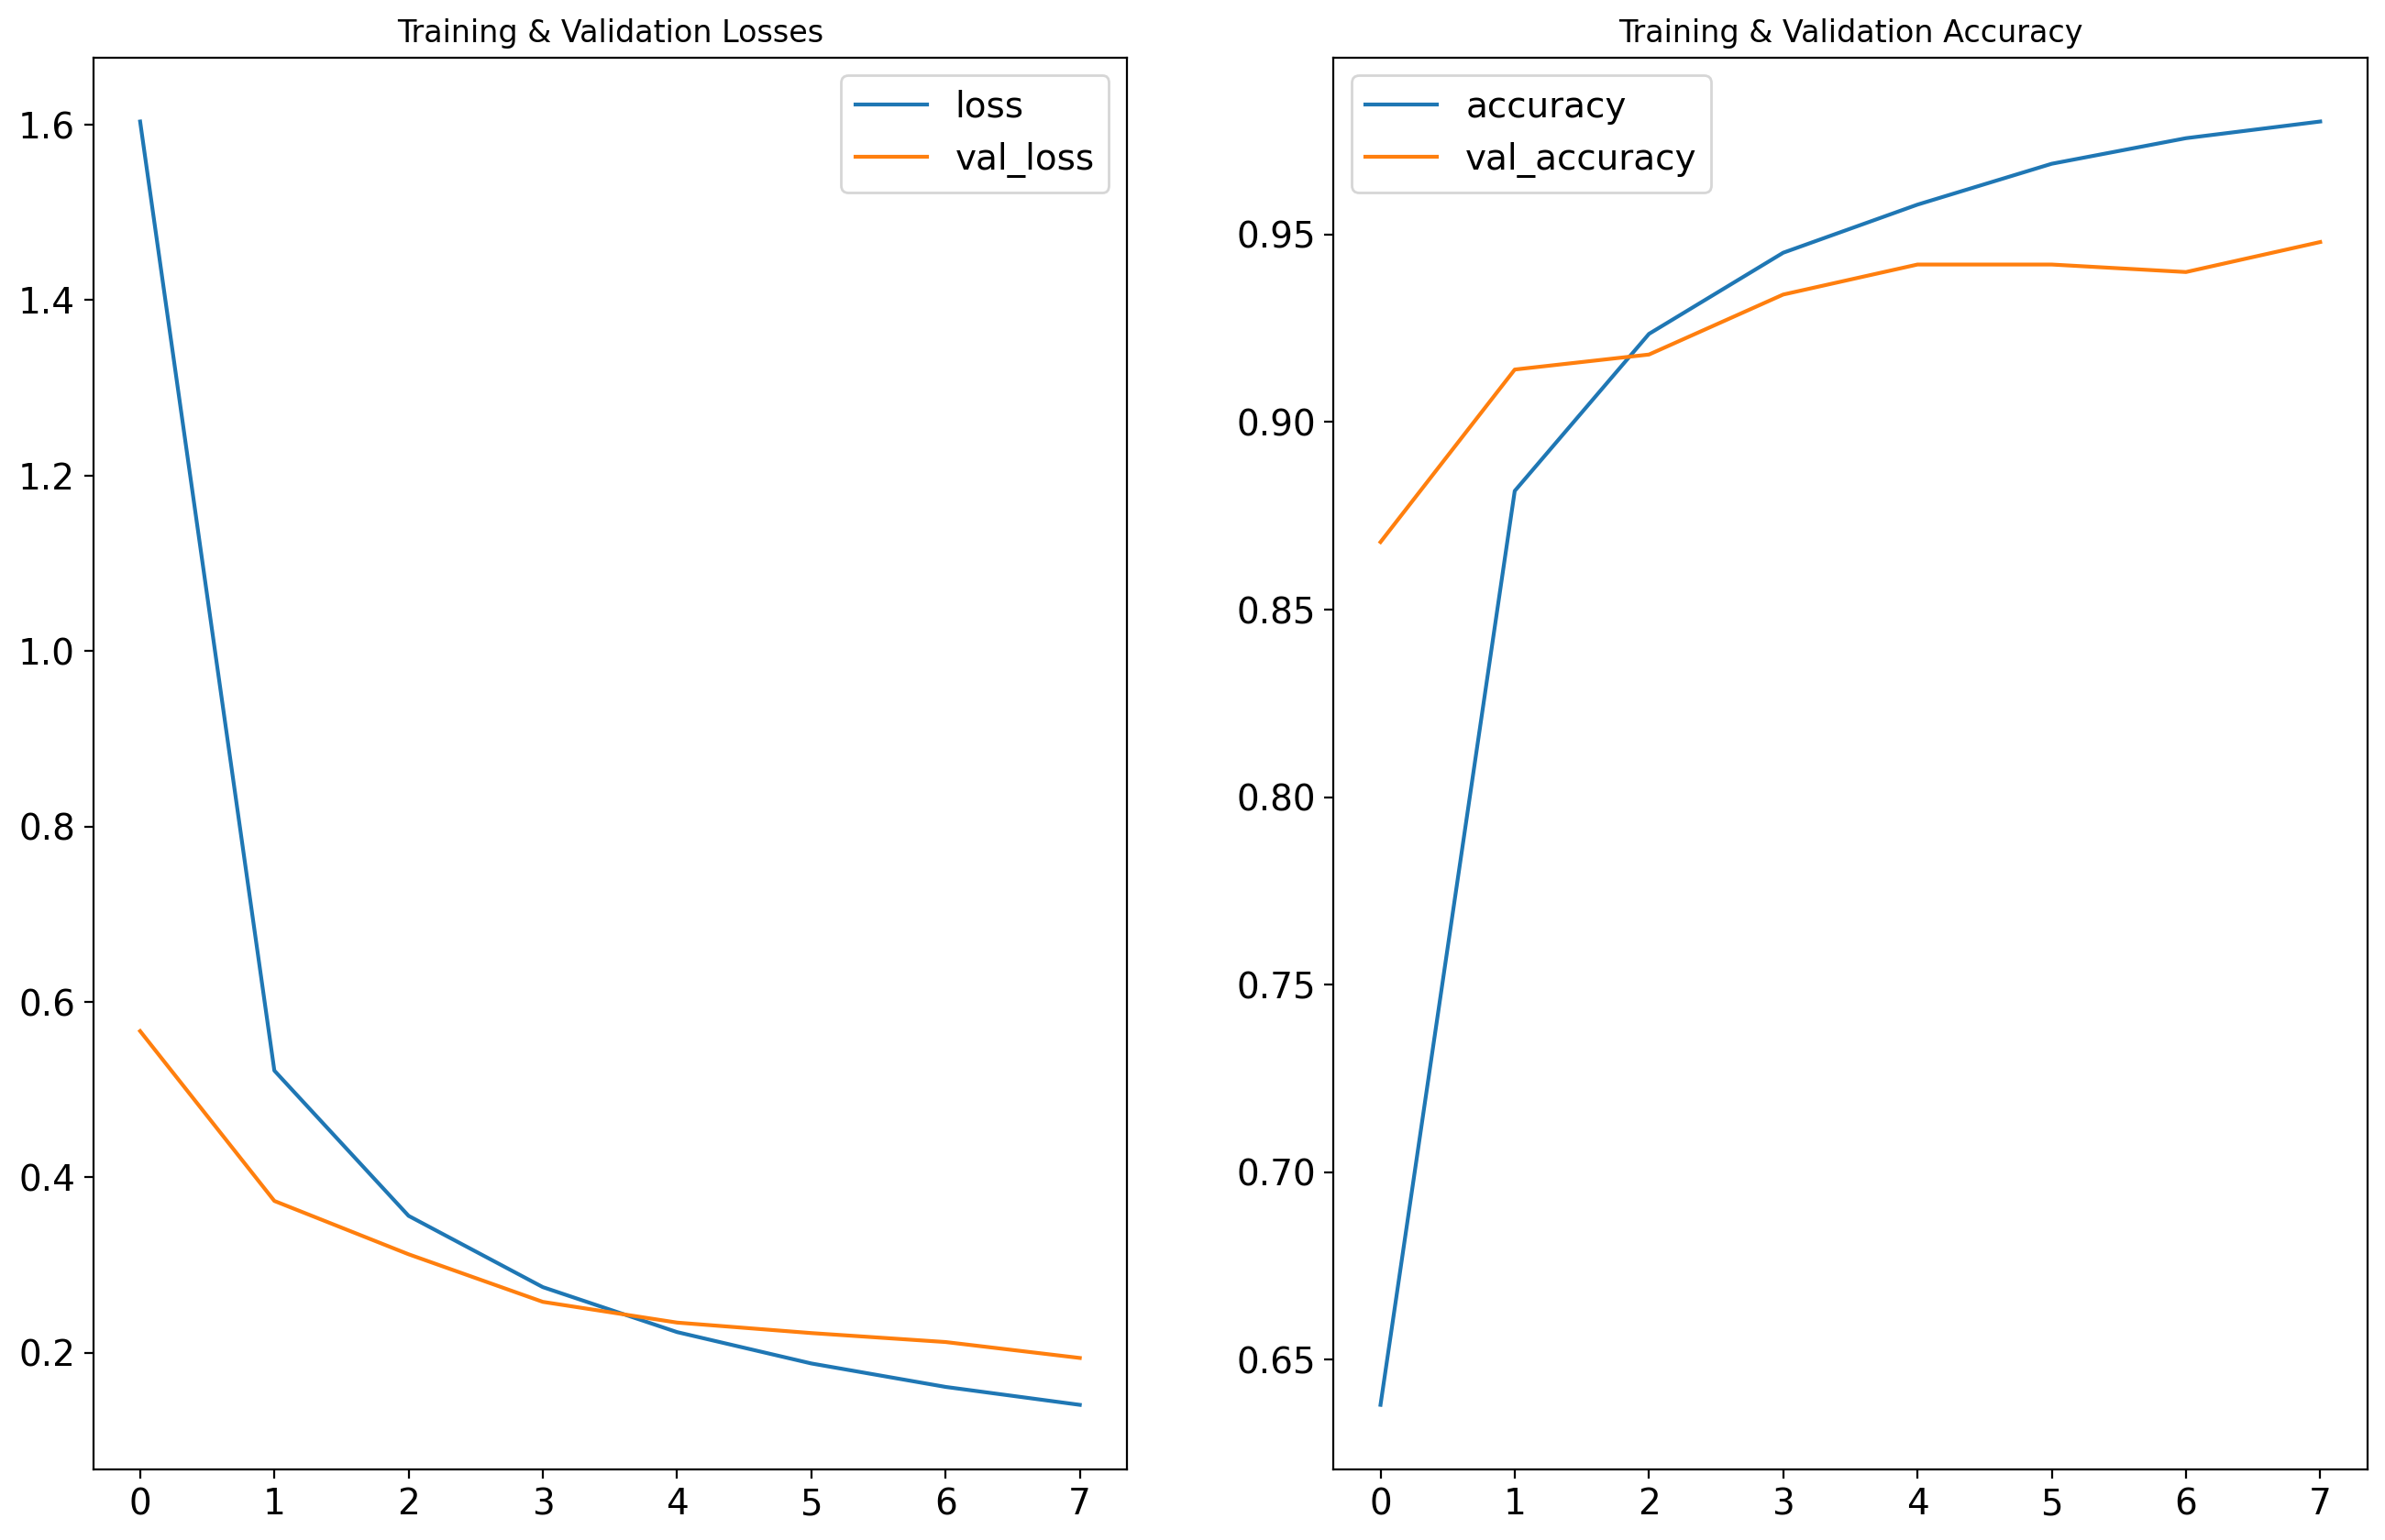

In [ ]:
train_func = ['loss', 'accuracy']
valid_func = ['val_loss', 'val_accuracy']
titles = [
    'Training & Validation Losses',
    'Training & Validation Accuracy'
]

def plotting_training_result(histories, title, i=1):
    plt.subplot(1, 2, i)
    for hist in histories:
        plt.plot(range(history_df.shape[0]), history_df[hist], label=hist)
    plt.title(title, fontsize=12)
    plt.legend()

for i in range(len(train_func)):
    plotting_training_result([train_func[i], valid_func[i]], title=titles[i], i=i+1)

In [ ]:
from keras.models import load_model

model.save('model.h5')

loaded_model = load_model('model.h5')

In [ ]:
tester = model.evaluate(test_generator)

print("Loss of the model is - " , tester[0])
print("Accuracy of the model is - " , tester[1]*100 , "%")

25/25 [==============================] - 2s 73ms/step - loss: 0.1781 - accuracy: 0.9460
Loss of the model is -  0.17810265719890594
Accuracy of the model is -  94.59999799728394 %
